# Pseudo-labeling a simple semi-supervised learning method
Using pseudo-labeling (semi-supervised learning technique) for Kaggl's [Mercedes-Benz Greener Manufacturing competition](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing). This notebook covers all the code from the [DataWhatNow](https://www.datawhatnow.com) - [Pseudo-labeling a simple semi-supervised learning method](https://datawhatnow.com/pseudo-labeling-semi-supervised-learning) blog post.

## Load the data
The dataset (train.csv and test.csv) come from the [Mercedes-Benz Greener Manufacturing competition](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing) competition on [Kaggle](https://www.kaggle.com/). To get the dataset download it from the official competition page on Kaggle https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data. If you want the code to work without changeing file paths, create an folder called "input" and put the datasets (train.csv and test.csv) inside it.

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

print(train.shape, test.shape)

(4209, 378) (4209, 377)


In [6]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


## Preprocessing
Some labels contain non-numeric values, we use the LabelEncoder from sklearn to convert those features to numberic ones.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
features = train.columns[2:]

for column_name in features:
    label_encoder = LabelEncoder() 
    
    # Get the column values
    train_column_values = list(train[column_name].values)
    test_column_values = list(test[column_name].values)
    
    # Fit the label encoder
    label_encoder.fit(train_column_values + test_column_values)
    
    # Transform the feature
    train[column_name] = label_encoder.transform(train_column_values)
    test[column_name] = label_encoder.transform(test_column_values)
    
train[train.columns[:12]].head(3)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11
0,0,130.81,37,23,20,0,3,27,9,14,0,0
1,6,88.53,37,21,22,4,3,31,11,14,0,0
2,7,76.26,24,24,38,2,3,30,9,23,0,0


In [9]:
target = 'y'

X_train, X_test = train[features], test[features]
y_train = train[target]

## Model exploration
In this section we explore the performance of couple of out-of-the-box models. The metric in which this competition is evaluate is **R2**.

In [10]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
model_factory = [
    RandomForestRegressor(),
    XGBRegressor(nthread=1),
    MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    num_folds = 3

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
    score_description = " %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-5 R2: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestRegressor     CV-5 R2:  0.42 (+/- 0.00)
XGBRegressor              CV-5 R2:  0.55 (+/- 0.06)
MLPRegressor              CV-5 R2:  0.49 (+/- 0.06)
Ridge                     CV-5 R2:  0.52 (+/- 0.08)
BayesianRidge             CV-5 R2:  0.54 (+/- 0.07)
ExtraTreesRegressor       CV-5 R2:  0.39 (+/- 0.04)
ElasticNet                CV-5 R2:  0.35 (+/- 0.06)
KNeighborsRegressor       CV-5 R2:  0.27 (+/- 0.04)
GradientBoostingRegressor CV-5 R2:  0.54 (+/- 0.07)


## Pseud-Labeler class
The PseudoLabler class is written as an sklearn estimator, check out the [official sklearn documentation](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) for more information.

In [12]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

### PseudoLabeler example

A simple example of how to use the PseudoLabler class. Simply wrap a sklearn regressor while passing the test set together with the list of features and target column.

In [13]:
model = PseudoLabeler(
    XGBRegressor(nthread=1),
    test,
    features,
    target
)

model.fit(X_train, y_train)
model.predict(X_train)

array([ 117.46550751,   91.85101318,   76.18600464, ...,  110.64896393,
         91.5431366 ,   93.63560486], dtype=float32)

### Comparing XGBoost with XGBoost using pseudo labeling

In [14]:
model_factory = [
    XGBRegressor(nthread=1),
    
    PseudoLabeler(
        XGBRegressor(nthread=1),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 8
    
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
    score_description = "R2: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

XGBRegressor              CV-8 R2: 0.5671 (+/- 0.1596)
PseudoLabeler             CV-8 R2: 0.5685 (+/- 0.1576)


## Performance of pseudo-labeling depending on sampling rate

**Warning** this might take some time to run.

Performance of pseudo-labeling based on different sample rates and machine learning models.

In [15]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [20]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestRegressor(n_jobs=1),
    XGBRegressor(),
    MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(n_jobs=1),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
        
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='r2', n_jobs=8)
        results[model_name].append(scores.mean())

RandomForestRegressor
XGBRegressor
MLPRegressor
Ridge
BayesianRidge
ExtraTreesRegressor
ElasticNet
KNeighborsRegressor
GradientBoostingRegressor


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


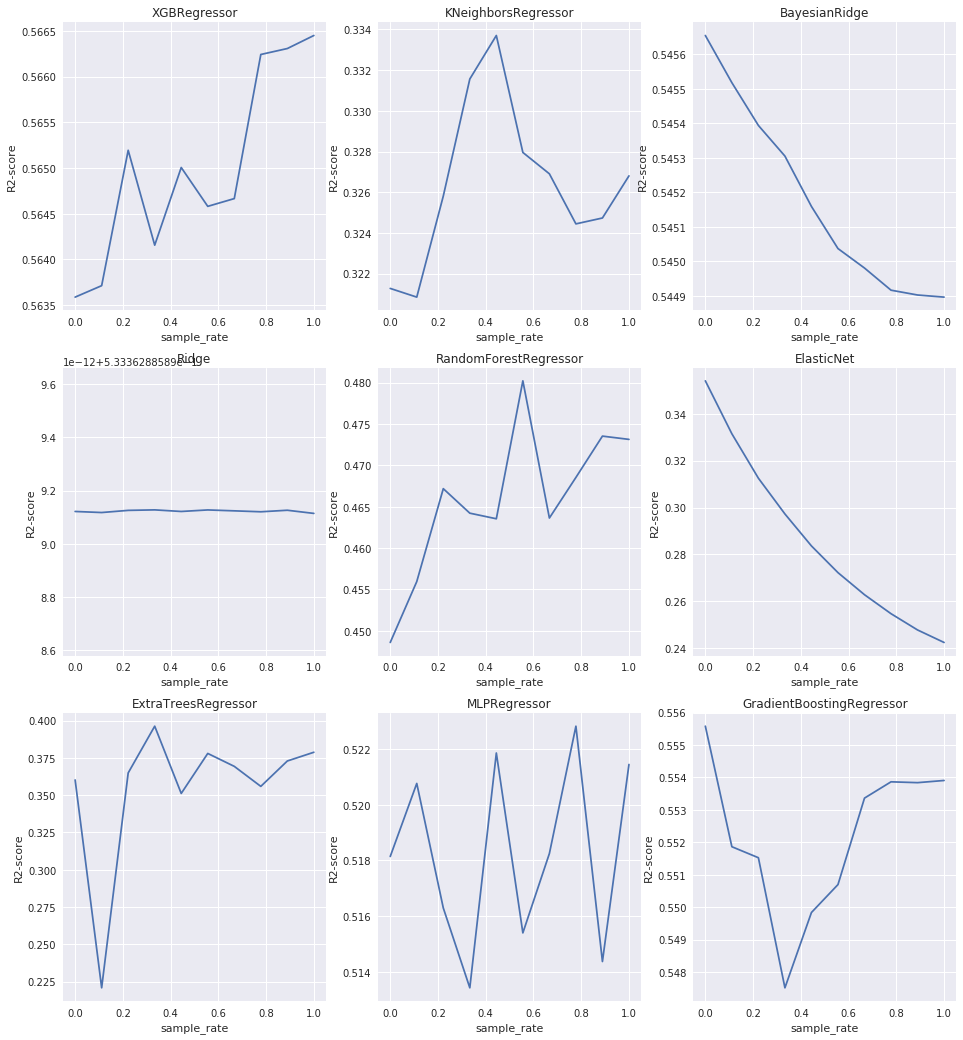

In [21]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('R2-score')
    

plt.show()